### Import libraries

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import math 
from sklearn.preprocessing import LabelEncoder
import shap
import os
import gzip

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

### Read  and analyze Lending Club Dataset
#### https://www.kaggle.com/datasets/wordsforthewise/lending-club?select=accepted_2007_to_2018Q4.csv.gz

In [11]:
input_data = os.path.join('..', 'raw', 'data', 'accepted_2007_to_2018Q4.csv.gz')

In [13]:
with gzip.open(input_data, 'rb') as f:
    df = pd.read_csv(f, low_memory=False)

In [5]:
df.shape

(2195670, 151)

In [6]:
#Response/Target Variable 
df.loan_status.value_counts()

Fully Paid                                             1048714
Current                                                 851419
Charged Off                                             259849
Late (31-120 days)                                       20652
In Grace Period                                           8055
Late (16-30 days)                                         4164
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     37
Name: loan_status, dtype: int64

In [15]:
#Considering only: Fully Paid, Default, Charged Off Loans.
resp=['Current']
loan_main = df[~df['loan_status'].isin(resp)] 
loan_main["loan_status"] = np.where(loan_main["loan_status"].str.contains("Fully"), 0, 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
#shape
loan_main.shape

(1382384, 151)

In [17]:
# Changing employee length to numerical.
loan_main['emp_length'].fillna("< 1 year",inplace= True)

dict_emp_length = {
    '10+ years':10, 
    '6 years':6, 
    '4 years':4, 
    '< 1 year':0.5, 
    '2 years':2,
    '9 years':9, 
    '5 years':5, 
    '3 years':3, 
    '7 years':7,
    '1 year':1,
    '8 years':8
}

loan_main['emp_length'].replace(dict_emp_length, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
#Seperating Loan_Main dataset into two based on Application_Type (Individual / Joint Type)
grouped = loan_main.groupby(loan_main.application_type)

individual_loan=grouped.get_group("Individual")
joint_loan=grouped.get_group("Joint App")

In [20]:
individual_loan.shape, joint_loan.shape

((1352767, 151), (29584, 151))

In [21]:
# Changing purpose into numerical using labelencoder
col=['purpose']
enc= LabelEncoder()
individual_loan.loc[:,col] = individual_loan.loc[:,col].apply(enc.fit_transform)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


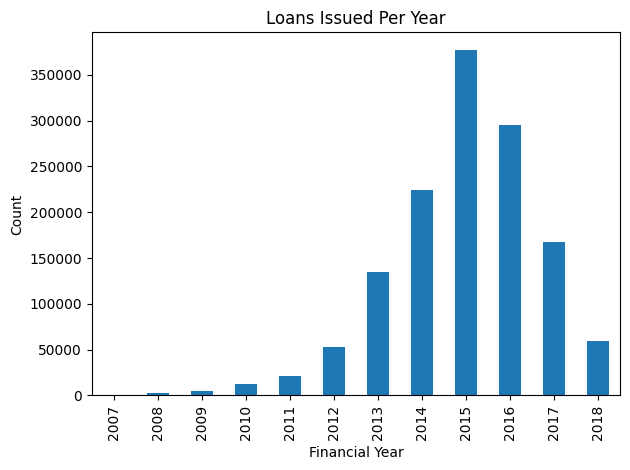

In [22]:
#Loan Issued over the years 

individual_loan['issue_d'] = pd.to_datetime(individual_loan['issue_d'])

individual_loan['issue_d'].dt.year.value_counts().sort_index().plot.bar()
plt.title('Loans Issued Per Year')
plt.xlabel('Financial Year')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

### Train and test dataset split

In [24]:
#set fraction
frac = 0.85

#get fractions and make deep copy
df_train = individual_loan.loc[individual_loan['issue_d']  < individual_loan['issue_d'].quantile(frac)]
df_test =  individual_loan.loc[individual_loan['issue_d'] >= individual_loan['issue_d'].quantile(frac)]

In [25]:
#save as compressed zipped files to save space
df_test.to_csv('../data/training_data/df_test.csv.zip')
df_train.to_csv('../data/training_data/df_train.csv.zip')

In [13]:
df_train.shape,df_test.shape

((1106465, 151), (209622, 151))